**Summary:**
    1. Лучшая точность в предыдущей работе на 30 категориях была 0.57. В этой работе я улучшил ее до 0.69.
    2. Мне получил точность 0.69 на 30 категориях с использованием как векторов Spacy, так и keras embeddings.
    3. Тренировка LSTM занимает очень много времени и в этой работе задействовать их не получилось (кроме пары экспериментов).
    4. Очень удобно использовать визуализацю history, чтобы определить оптимальное количество эпох для тренировки.
    5. Обертка KerasClassifier позволила мне использовать уже знакомые инструменты из scikit-learn

# Infrastructure setup

## Initilizing the runtime (runtime)

In [128]:
%env local_data_path = /Users/dmytromindra/Projects/prj-nlp-2020/students/DmytroMindra/11-nn/data/
!echo "data path: ${local_data_path}"

# 1551 Dataset has lots of small files. Reading them from mounted Google Drive
# sometimes takes significant time, so I have decided to checkout it to VM
# DATA_1551_PATH = '/content/drive/My  Drive/Colab/homework-10/1551.gov.ua/raw/'
DATA_1551_PATH = '/Users/dmytromindra/Projects/prj-nlp-2020/students/DmytroMindra/11-nn/data/1551.gov.ua/raw/'


#
# Working with word2vec models
#

models_path = '/Users/dmytromindra/Projects/prj-nlp-2020/students/DmytroMindra/11-nn/data/vec_models/'
ubercorpus_cased_tokenized_word2vec_300d_path = models_path + 'ubercorpus.cased.tokenized.word2vec.300d'

#
# An amazing progress bar function
#

def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)

    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '')
    # Print New Line on Complete
    if iteration == total: 
        print()

printProgressBar(1, 10, prefix = 'Progress:', suffix = 'Complete', length = 50)        
printProgressBar(1, 100, prefix = 'Progress:', suffix = 'Complete', length = 50)

env: local_data_path=/Users/dmytromindra/Projects/prj-nlp-2020/students/DmytroMindra/11-nn/data/
data path: /Users/dmytromindra/Projects/prj-nlp-2020/students/DmytroMindra/11-nn/data/
Progress: |--------------------------------------------------| 1.0% Completee

## Downloading the data (once)


### Donwloading 1551 data

In [2]:
!git clone https://github.com/lang-uk/1551.gov.ua ${local_data_path}1551.gov.ua

Cloning into '/Users/dmytromindra/Projects/prj-nlp-2020/students/DmytroMindra/11-nn/data/1551.gov.ua'...
remote: Enumerating objects: 127370, done.
remote: Total 127370 (delta 0), reused 0 (delta 0), pack-reused 127370bjects:   6% (7643/127370), 3.89 MiB | 3.87 MiB/sReceiving objects:   8% (10190/127370), 6.82 MiB | 4.52 MiB/sReceiving objects:  10% (12737/127370), 10.04 MiB | 5.00 MiB/sReceiving objects:  12% (15285/127370), 10.04 MiB | 5.00 MiB/sReceiving objects:  14% (17832/127370), 13.23 MiB | 5.27 MiB/sReceiving objects:  15% (19460/127370), 13.23 MiB | 5.27 MiB/sReceiving objects:  17% (21653/127370), 16.96 MiB | 5.63 MiB/sReceiving objects:  19% (24201/127370), 20.60 MiB | 5.86 MiB/sReceiving objects:  21% (26748/127370), 20.60 MiB | 5.86 MiB/sReceiving objects:  22% (28022/127370), 23.75 MiB | 5.92 MiB/sReceiving objects:  24% (30569/127370), 23.75 MiB | 5.92 MiB/sReceiving objects:  26% (33117/127370), 27.11 MiB | 6.00 MiB/sReceiving objects:  27% (35373/127370), 27.11 MiB | 

### Downloading **ubercorpus**

В домашней работе №10, **ubercorpus cased tokenized** показал хороший результат. В этой работе я буду использовать языковую модель на его основе.

In [3]:
!wget -P ${local_data_path} https://lang.org.ua/static/downloads/models/ubercorpus.cased.tokenized.word2vec.300d.bz2
!bzip2 -d ${local_data_path}ubercorpus.cased.tokenized.word2vec.300d.bz2

--2020-05-23 20:28:04--  https://lang.org.ua/static/downloads/models/ubercorpus.cased.tokenized.word2vec.300d.bz2
Resolving lang.org.ua (lang.org.ua)... 95.216.74.77
Connecting to lang.org.ua (lang.org.ua)|95.216.74.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 555203899 (529M) [application/octet-stream]
Saving to: ‘/Users/dmytromindra/Projects/prj-nlp-2020/students/DmytroMindra/11-nn/data/ubercorpus.cased.tokenized.word2vec.300d.bz2’

ubercorpus.cased.to 100%[===================>] 529,48M  8,36MB/s    in 80s     

2020-05-23 20:29:24 (6,62 MB/s) - ‘/Users/dmytromindra/Projects/prj-nlp-2020/students/DmytroMindra/11-nn/data/ubercorpus.cased.tokenized.word2vec.300d.bz2’ saved [555203899/555203899]



## Installing pymorphy (once)

In [7]:
!pip uninstall pymorphy2-dicts-uk -y
!pip uninstall pymorphy2 -y
!pip install spacy
!pip install git+https://github.com/kmike/pymorphy2.git pymorphy2-dicts-uk

Found existing installation: pymorphy2-dicts-uk 2.4.1.1.1460299261
Uninstalling pymorphy2-dicts-uk-2.4.1.1.1460299261:
  Successfully uninstalled pymorphy2-dicts-uk-2.4.1.1.1460299261
Found existing installation: pymorphy2 0.8
Uninstalling pymorphy2-0.8:
  Successfully uninstalled pymorphy2-0.8
  Using cached spacy-2.2.4-cp38-cp38-macosx_10_9_x86_64.whl (10.6 MB)
  Using cached srsly-1.0.2-cp38-cp38-macosx_10_9_x86_64.whl (183 kB)
  Using cached wasabi-0.6.0-py3-none-any.whl (20 kB)
  Using cached plac-1.1.3-py2.py3-none-any.whl (20 kB)
  Using cached thinc-7.4.0-cp38-cp38-macosx_10_9_x86_64.whl (2.2 MB)
  Using cached catalogue-1.0.0-py2.py3-none-any.whl (7.7 kB)
  Using cached preshed-3.0.2-cp38-cp38-macosx_10_9_x86_64.whl (112 kB)
  Using cached cymem-2.0.3-cp38-cp38-macosx_10_9_x86_64.whl (31 kB)
  Using cached requests-2.23.0-py2.py3-none-any.whl (58 kB)
  Using cached tqdm-4.46.0-py2.py3-none-any.whl (63 kB)
  Using cached blis-0.4.1-cp38-cp38-macosx_10_9_x86_64.whl (3.7 MB)
  Us

## Initializing models

In [8]:
!rm -r ${local_data_path}vec_models
!mkdir ${local_data_path}vec_models
!
# ubercorpus.cased.tokenized.word2vec.300d
!python -m spacy init-model uk ${local_data_path}vec_models/ubercorpus.cased.tokenized.word2vec.300d --vectors-loc ${local_data_path}ubercorpus.cased.tokenized.word2vec.300d

eating model...✔ Successfully created model
595119it [00:55, 10683.68it/s]dmytromindra/Projects/prj-nlp-2020/students/DmytroMindra/11-nn/data/ubercorpus.cased.tokenized.word2vec.300d
✔ Loaded vectors from
/Users/dmytromindra/Projects/prj-nlp-2020/students/DmytroMindra/11-nn/data/ubercorpus.cased.tokenized.word2vec.300d
✔ Sucessfully compiled vocab
595290 entries, 595119 vectors


### Testing if pymorphy model works

In [3]:
import spacy
ubercorpus_cased_tokenized_model = spacy.load(ubercorpus_cased_tokenized_word2vec_300d_path)

In [5]:
w1 = ubercorpus_cased_tokenized_model('кіт')
w2 = ubercorpus_cased_tokenized_model('собака')
print(w1.similarity(w2))

0.707450064131281


## Language detector (once)

In [6]:
!python -m pip install -U pycld2

import pycld2 as cld2

isReliable, textBytesFound, details = cld2.detect(
    "Відкриття спортивних залів не підлягає нинішнім карантинним пом'якшенням."
)

print (details[0][1])

  Using cached pycld2-0.41.tar.gz (41.4 MB)
Using legacy setup.py install for pycld2, since package 'wheel' is not installed.
    Running setup.py install for pycld2 ... done
uk


# Data

## Doc2Vec (runtime)

In [ ]:
В этой работе я использую векторизацию с фильтрацией стоп слов.

In [7]:
def vectorize_without_stopwords(text, model):
    words = model(text)
    filtered_words = []

    for w in words:
      if w not in spacy.lang.uk.stop_words.STOP_WORDS:
        filtered_words.append(w.text)

    words = model(' '.join(filtered_words))
    return words.vector

## Loading the data in memory (runtime)

In [129]:
import gzip
import json
import glob

import time

def read_file(f):
    with gzip.open(f, 'rt', encoding='utf-8') as inf:
        j = json.load(inf)
        return j[0]

start = time.time()

data = []
files = []

for f in glob.glob(DATA_1551_PATH+'*/*'):
  files.append(f)

print('Files count', len(files))
counter = 0
for file in files:
  data.append(read_file(file))
  counter+=1
  if counter%100 ==0:
    #print (len(files) - counter,'/',len(files))
    printProgressBar(counter, len(files), prefix = 'Progress:', suffix = 'Complete', length = 50)

printProgressBar(counter, len(files), prefix = 'Progress:', suffix = 'Complete', length = 50)
print()
print ('Data loaded:',len(data))

end = time.time()
print('Time elapsed:', end - start, 'seconds')


Files count 127329
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Data loaded: 127329
Time elapsed: 83.56087183952332 seconds


## Selecting a subset of data for fast processing (runtime)

Данные долго обрабатываются. Большую часть экспериментов я буду провдоить на небольшом подмножестве данных. Для этого я сначала буду вызывать метод __get_top_categories__ для получения данных, а затем __get_vectorized_data__ для преобразования данных в векторы.

In [10]:
import pycld2 as cld2
category_id = {}

def get_top_categories (n_categories, filter_ukrainian = False):
  categories_count = {}
  counter = 0

  for data_item in data:
    if data_item['CallZType'] not in categories_count:
      categories_count[data_item['CallZType']] = 0
      category_id[data_item['CallZType']] = counter
      counter+=1
    categories_count[data_item['CallZType']]+=1


  def takeSecond(elem):
      return elem[1]


  category_statistics = []

  for category in categories_count:
    category_statistics.append((category, categories_count[category]))

  category_statistics.sort(key=takeSecond, reverse=True)

  selected_categories = {}

  for category in category_statistics[:n_categories]:
      selected_categories[category[0]] = []

  for data_item in data:

      if filter_ukrainian:
        printable_str = ''.join(x for x in data_item['CallZText'] if x.isprintable())
        isReliable, textBytesFound, details = cld2.detect(printable_str)
        if details[0][1]=='uk' and data_item['CallZType'] in selected_categories:
          selected_categories[data_item['CallZType']].append(data_item['CallZText'])

      elif data_item['CallZType'] in selected_categories:
        selected_categories[data_item['CallZType']].append(data_item['CallZText'])
  
  return selected_categories


def get_vectorized_data(source_data, vectorizer, model):

  features = []
  labels = []

  for category in source_data:
    for data_item in source_data[category]:
      vectorized_data = vectorizer(data_item, model)
      if vectorized_data is not None:
        features.append(vectorized_data)
        labels.append(category_id[category])

  return features, labels


# Iterations

В качестве **Baseline**, я переиспользую _*KNeighborsClassifier*_ из предыдущей работы. 

## Baseline (from Homework 10)

In [12]:
!pip install sklearn

  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Using cached scikit_learn-0.23.1-cp38-cp38-macosx_10_9_x86_64.whl (7.2 MB)
  Using cached joblib-0.15.1-py3-none-any.whl (298 kB)
  Using cached scipy-1.4.1-cp38-cp38-macosx_10_9_x86_64.whl (28.8 MB)
  Using cached threadpoolctl-2.0.0-py3-none-any.whl (34 kB)
Using legacy setup.py install for sklearn, since package 'wheel' is not installed.
    Running setup.py install for sklearn ... done


In [262]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report

filtered_data = get_top_categories(30)

X, y = get_vectorized_data(filtered_data, vectorizer = vectorize_without_stopwords, model = ubercorpus_cased_tokenized_model)

print (len(X), len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

neighbors = KNeighborsClassifier(n_neighbors=3, n_jobs = -1)
neighbors.fit(np.array(X_train), np.array(y_train))

y_pred = neighbors.predict(X_test)


print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print()

print(classification_report(y_test, y_pred))


71741 71741
Accuracy: 0.4013938753959873

              precision    recall  f1-score   support

           1       0.45      0.78      0.57      4310
           4       0.37      0.50      0.42      1053
           8       0.21      0.27      0.24       659
           9       0.19      0.21      0.20       467
          10       0.33      0.40      0.36       863
          13       0.32      0.32      0.32       794
          14       0.42      0.36      0.39      1963
          16       0.19      0.21      0.20       351
          18       0.20      0.34      0.25       442
          20       0.27      0.33      0.30       814
          21       0.48      0.49      0.49       619
          24       0.38      0.45      0.41       382
          25       0.49      0.40      0.44       893
          31       0.32      0.30      0.31       663
          35       0.52      0.37      0.43      2226
          39       0.35      0.13      0.19       502
          41       0.44      0.25      

## MLPClassifier + GridSearchCV (best result from homework 10)

In [288]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report

filtered_data = get_top_categories(30)

X, y = get_vectorized_data(filtered_data, vectorizer = vectorize_without_stopwords, model = ubercorpus_cased_tokenized_model)

print (len(X), len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = MLPClassifier(alpha = 0.1, hidden_layer_sizes = 14, max_iter = 400, solver = 'lbfgs', verbose=1, random_state=42)
clf.fit(np.array(X_train), np.array(y_train))

print(clf.score(X_train, y_train))

y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print()

print(classification_report(y_test, y_pred))

71741 71741


/Users/dmytromindra/Projects/prj-nlp-2020/students/DmytroMindra/11-nn/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.6068738817459327
Accuracy: 0.5783315733896516

              precision    recall  f1-score   support

           1       0.67      0.86      0.75      4310
           4       0.64      0.57      0.60      1053
           8       0.50      0.36      0.42       659
           9       0.52      0.45      0.48       467
          10       0.45      0.72      0.55       863
          13       0.58      0.52      0.55       794
          14       0.61      0.67      0.64      1963
          16       0.36      0.31      0.33       351
          18       0.51      0.44      0.47       442
          20       0.58      0.34      0.42       814
          21       0.64      0.64      0.64       619
          24       0.65      0.61      0.63       382
          25       0.59      0.71      0.64       893
          31       0.54      0.56      0.55       663
          35       0.56      0.74      0.64      2226
          39       0.58      0.23      0.33       502
          41       0.60      0.0

## Neural Networks ( Homework 11 )

In [19]:
!pip install tensorflow

     |████████████████████████████████| 175.4 MB 4.9 MB/s eta 0:00:017
     |████████████████████████████████| 63 kB 2.7 MB/s eta 0:00:011
     |████████████████████████████████| 1.3 MB 5.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 454 kB 6.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 7.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 6.8 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.1 MB/s  eta 0:00:01
     |████████████████████████████████| 104 kB 10.5 MB/s eta 0:00:01
     |████████████████████████████████| 89 kB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 777 kB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 298 kB 9.1 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 4.4 MB/s eta 0:00:011
     |████████████████████████████████| 155 kB

In [31]:
!pip install keras

     |████████████████████████████████| 377 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 269 kB 6.7 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 4.9 MB/s eta 0:00:01
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp38-cp38-macosx_10_9_x86_64.whl size=44624 sha256=193ca6038ef6e09ad578e05bd01e0334ccba97bd044feebbc3756a9225829b0d
  Stored in directory: /Users/dmytromindra/Library/Caches/pip/wheels/13/90/db/290ab3a34f2ef0b5a0f89235dc2d40fea83e77de84ed2dc05c
Successfully built pyyaml


## Using Spacy based vectorization with Sequential NN 

In [263]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

n_categories = 30

language_model = spacy.load(ubercorpus_cased_tokenized_word2vec_300d_path)
filtered_data = get_top_categories(n_categories, filter_ukrainian=True)
X, y = get_vectorized_data(filtered_data, vectorizer = vectorize_without_stopwords, model = language_model)
print (len(X), len(y))

38077 38077


In [267]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoded_y = encoder.fit_transform(y)

print(np.array(y))
print(encoded_y)
print (len(set(encoded_y)))

[ 1  1  1 ... 55 55 55]
[ 0  0  0 ... 19 19 19]
30


In [268]:
X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size=0.33, random_state=42)
print ('train:', len(X_train), len(y_train))
print ('test:', len(X_test), len(y_test))

X_train = np.array(X_train)
X_test = np.array(X_test)

print ('X_train shape', X_train.shape)
print ('X_test shape', X_test.shape)


train: 25511 25511
test: 12566 12566
X_train shape (25511, 300)
X_test shape (12566, 300)


Благодаря **KerasClassifier**, мы получили возможность использовать **classification_report** для нейронки.

In [277]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten
from keras.wrappers.scikit_learn import KerasClassifier

print (X_train.shape)

input_dim = X_train.shape[1]

def get_model():
    global input_dim
    model = Sequential()
    model.add(Dense(100, input_dim=input_dim, activation='relu'))
    model.add(Dense(n_categories, activation='softmax')) 
    model.summary()
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=get_model, nb_epoch=10, batch_size=5, verbose=0)
estimator.fit(np.array(X_train), np.array(y_train), epochs=10, verbose=2)

history = estimator.model.fit(X_train, y_train,
                    epochs=10,
                    verbose=2,
                    validation_data=(X_test, y_test),
                    batch_size=10)


(25511, 300)
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_82 (Dense)             (None, 30)                3030      
Total params: 33,130
Trainable params: 33,130
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 - 4s - loss: 1.4188 - accuracy: 0.5690
Epoch 2/10
 - 4s - loss: 1.0172 - accuracy: 0.6679
Epoch 3/10
 - 4s - loss: 0.9273 - accuracy: 0.6961
Epoch 4/10
 - 4s - loss: 0.8695 - accuracy: 0.7134
Epoch 5/10
 - 5s - loss: 0.8257 - accuracy: 0.7236
Epoch 6/10
 - 5s - loss: 0.7864 - accuracy: 0.7363
Epoch 7/10
 - 5s - loss: 0.7582 - accuracy: 0.7455
Epoch 8/10
 - 5s - loss: 0.7246 - accuracy: 0.7569
Epoch 9/10
 - 5s - loss: 0.7008 - accuracy: 0.7637
Epoch 10/10
 - 4s - loss: 0.6755 - accu

In [279]:
y_pred = estimator.predict(np.array(X_test))

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
loss, accuracy = estimator.model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = estimator.model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

print(classification_report(y_test, y_pred))


Accuracy: 0.6929014801846252
Training Accuracy: 0.8544
Testing Accuracy:  0.6929
              precision    recall  f1-score   support

           0       0.78      0.87      0.83      2214
           1       0.76      0.81      0.78       572
           2       0.54      0.58      0.56       317
           3       0.63      0.58      0.60       210
           4       0.63      0.42      0.51       420
           5       0.61      0.56      0.58       377
           6       0.75      0.72      0.73      1050
           7       0.60      0.42      0.50       195
           8       0.68      0.77      0.72       232
           9       0.65      0.64      0.64       438
          10       0.71      0.77      0.74       370
          11       0.83      0.83      0.83       206
          12       0.82      0.67      0.74       398
          13       0.61      0.72      0.66       369
          14       0.71      0.72      0.71      1235
          15       0.59      0.55      0.57       250


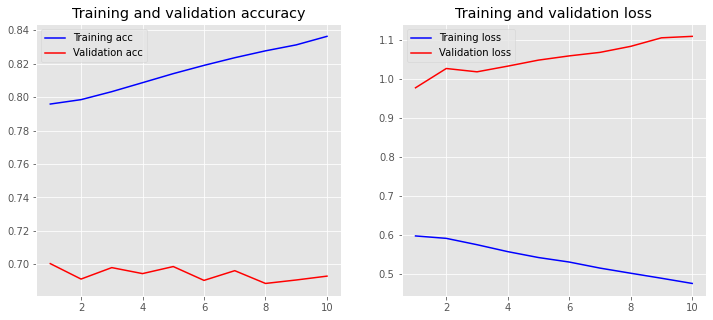

In [278]:
plot_history(history)

Простая нейронка показала accuracy 0.69 (Baseline = 0.40) на Spacy эмбедингах. Но за 10 итераций не успела заоверфититься на тренировочные данные.

In [146]:
!pip install matplotlib

  Using cached matplotlib-3.2.1-cp38-cp38-macosx_10_9_x86_64.whl (12.4 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached kiwisolver-1.2.0-cp38-cp38-macosx_10_9_x86_64.whl (60 kB)


In [280]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [283]:
history = estimator.model.fit(X_train, y_train,
                    epochs=40,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Train on 25511 samples, validate on 12566 samples
Epoch 1/40
25511/25511 [==============================] - 3s 137us/step - loss: 0.3542 - accuracy: 0.8796 - val_loss: 1.3719 - val_accuracy: 0.6833
Epoch 2/40
25511/25511 [==============================] - 3s 133us/step - loss: 0.3430 - accuracy: 0.8810 - val_loss: 1.3589 - val_accuracy: 0.6820
Epoch 3/40
25511/25511 [==============================] - 3s 133us/step - loss: 0.3343 - accuracy: 0.8853 - val_loss: 1.3951 - val_accuracy: 0.6865
Epoch 4/40
25511/25511 [==============================] - 3s 135us/step - loss: 0.3276 - accuracy: 0.8872 - val_loss: 1.4271 - val_accuracy: 0.6831
Epoch 5/40
25511/25511 [==============================] - 3s 135us/step - loss: 0.3179 - accuracy: 0.8919 - val_loss: 1.4205 - val_accuracy: 0.6857
Epoch 6/40
25511/25511 [==============================] - 3s 136us/step - loss: 0.3177 - accuracy: 0.8915 - val_loss: 1.4698 - val_accuracy: 0.6821
Epoch 7/40
25511/25511 [==============================] - 4s 1

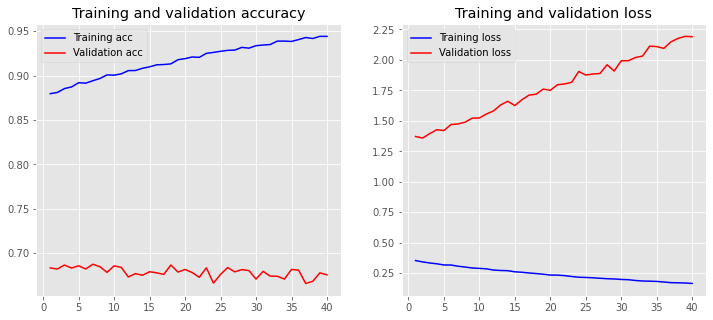

In [284]:
plot_history(history)

## one_hot and pad_sequences

In [192]:
num_categories = 30

filtered_data = get_top_categories(num_categories, filter_ukrainian=True)

In [196]:
labels  = []
documents = []

for category in filtered_data:
    for document in filtered_data[category]:
        labels.append (category)
        documents.append(document)

print (len(labels))
print (len(documents))


38077
38077


In [204]:
vocab_size = 5000
encoded_docs = [one_hot(d, vocab_size) for d in documents]
print(encoded_docs[:2])

[[660, 2431, 100, 3002, 2456, 100, 4300, 1925, 826, 3331, 3002, 3333, 3858, 2403, 2497, 3184, 1339, 3297, 4780, 3577, 4905, 1205, 4153, 2579, 1086, 1306, 3554, 1733, 2354, 442, 4498, 648, 1733, 3331, 1306, 4153, 3038, 960, 2886, 2129, 2054, 4504, 3797, 2795, 1898, 2795, 1673, 960, 1754, 295, 4180, 1292, 3731, 2599, 3604, 2031, 3545], [4806, 2919, 2817, 892, 663, 1815, 78, 4770, 4950, 3456, 410, 4498, 2284, 300, 4317, 4673, 1396, 4352, 3103, 3103, 4365, 4048, 4262, 4270, 3016, 2428, 2795, 3845, 4498, 3537, 2031, 2311, 4048, 2795, 1396, 4352, 1606, 159, 2461, 2354, 1422, 1104, 1001, 887, 1292, 3769, 3405, 1887, 2451, 2764, 1104, 3297, 560, 293, 1045, 3840, 300, 4317, 3103, 3103, 1104, 2006, 1046, 14, 2289, 4131, 3613, 2926, 1292, 1714, 4299, 1104, 2006, 37, 833, 3343, 2846, 4317, 3385, 440, 1914, 3104, 1041, 892, 189, 4177, 3384, 1104, 4360, 2381, 440, 662, 1, 4123, 4009, 1988, 1887, 987, 1104, 4977, 2570, 3650, 3103, 3103, 4498, 2855, 3385, 2165, 2428, 3755, 38, 2156, 1292, 3218, 2730, 

In [210]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 100
padded_docs = pad_sequences(encoded_docs, padding='post', maxlen=maxlen)
print(padded_docs[:2])

[[ 660 2431  100 3002 2456  100 4300 1925  826 3331 3002 3333 3858 2403
  2497 3184 1339 3297 4780 3577 4905 1205 4153 2579 1086 1306 3554 1733
  2354  442 4498  648 1733 3331 1306 4153 3038  960 2886 2129 2054 4504
  3797 2795 1898 2795 1673  960 1754  295 4180 1292 3731 2599 3604 2031
  3545    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [2031 2311 4048 2795 1396 4352 1606  159 2461 2354 1422 1104 1001  887
  1292 3769 3405 1887 2451 2764 1104 3297  560  293 1045 3840  300 4317
  3103 3103 1104 2006 1046   14 2289 4131 3613 2926 1292 1714 4299 1104
  2006   37  833 3343 2846 4317 3385  440 1914 3104 1041  892  189 4177
  3384 1104 4360 2381  440  662    1 4123 4009 1988 1887  987 1104 4977
  2570 3650 3103 3103 4498 2855 3385 2165 2428 3755   38 2156 1292 3218
  2730  300  892 4946 4317 4529  892 2795 4293   16

In [219]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

encoded_labels = encoder.fit_transform(labels)

print(labels[:2])
print(encoded_labels[:2])

['Відсутність ГВП', 'Відсутність ГВП']
[4 4]


In [224]:
X_train, X_test, y_train, y_test = train_test_split(padded_docs, encoded_labels, test_size=0.33, random_state=42)
print ('train',len(X_train),len(y_train))
print ('test',len(X_test),len(y_test))

train 25511 25511
test 12566 12566


In [232]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(num_categories, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 50)           250000    
_________________________________________________________________
flatten_5 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_69 (Dense)             (None, 100)               500100    
_________________________________________________________________
dense_70 (Dense)             (None, 30)                3030      
Total params: 753,130
Trainable params: 753,130
Non-trainable params: 0
_________________________________________________________________


Train on 25511 samples, validate on 12566 samples
Epoch 1/20
 - 20s - loss: 1.6299 - accuracy: 0.5215 - val_loss: 1.0682 - val_accuracy: 0.6632
Epoch 2/20
 - 20s - loss: 0.5319 - accuracy: 0.8332 - val_loss: 1.1290 - val_accuracy: 0.6691
Epoch 3/20
 - 20s - loss: 0.1860 - accuracy: 0.9467 - val_loss: 1.3801 - val_accuracy: 0.6678
Epoch 4/20
 - 20s - loss: 0.0954 - accuracy: 0.9767 - val_loss: 1.6136 - val_accuracy: 0.6572
Epoch 5/20
 - 20s - loss: 0.0616 - accuracy: 0.9865 - val_loss: 1.8739 - val_accuracy: 0.6580
Epoch 6/20
 - 20s - loss: 0.0472 - accuracy: 0.9882 - val_loss: 2.1382 - val_accuracy: 0.6436
Epoch 7/20
 - 20s - loss: 0.0394 - accuracy: 0.9896 - val_loss: 2.4240 - val_accuracy: 0.6386
Epoch 8/20
 - 20s - loss: 0.0330 - accuracy: 0.9913 - val_loss: 2.6077 - val_accuracy: 0.6372
Epoch 9/20
 - 20s - loss: 0.0313 - accuracy: 0.9918 - val_loss: 2.8472 - val_accuracy: 0.6306
Epoch 10/20
 - 20s - loss: 0.0320 - accuracy: 0.9913 - val_loss: 3.0877 - val_accuracy: 0.6330
Epoch 11/

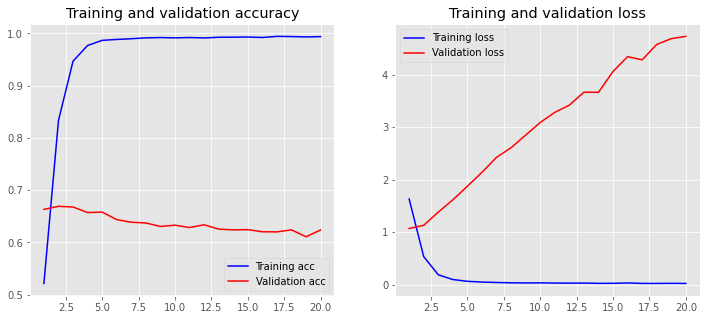

In [233]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=2,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Модель очень быстро заоверфитилась на тестовые данные. Можно было прервать тренировку на 5-й эпохе и получить точность 0.65 (лучший результат = 0.69; baseline = 0.40 )

## Conv1D and GlobalMaxPooling1D

In [230]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(num_categories, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 50)           250000    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 96, 128)           32128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 100)               12900     
_________________________________________________________________
dense_68 (Dense)             (None, 30)                3030      
Total params: 298,058
Trainable params: 298,058
Non-trainable params: 0
_________________________________________________________________


Train on 25511 samples, validate on 12566 samples
Epoch 1/20
 - 16s - loss: 1.5730 - accuracy: 0.5305 - val_loss: 1.0638 - val_accuracy: 0.6580
Epoch 2/20
 - 16s - loss: 0.8115 - accuracy: 0.7316 - val_loss: 0.9447 - val_accuracy: 0.6969
Epoch 3/20
 - 15s - loss: 0.5204 - accuracy: 0.8201 - val_loss: 1.0361 - val_accuracy: 0.6938
Epoch 4/20
 - 18s - loss: 0.3218 - accuracy: 0.8929 - val_loss: 1.1405 - val_accuracy: 0.6989
Epoch 5/20
 - 17s - loss: 0.1952 - accuracy: 0.9387 - val_loss: 1.3550 - val_accuracy: 0.6901
Epoch 6/20
 - 16s - loss: 0.1347 - accuracy: 0.9592 - val_loss: 1.5375 - val_accuracy: 0.6880
Epoch 7/20
 - 17s - loss: 0.1001 - accuracy: 0.9723 - val_loss: 1.7106 - val_accuracy: 0.6837
Epoch 8/20
 - 21s - loss: 0.0887 - accuracy: 0.9773 - val_loss: 1.7671 - val_accuracy: 0.6949
Epoch 9/20
 - 19s - loss: 0.0808 - accuracy: 0.9782 - val_loss: 2.0467 - val_accuracy: 0.6861
Epoch 10/20
 - 19s - loss: 0.0793 - accuracy: 0.9804 - val_loss: 2.0813 - val_accuracy: 0.6861
Epoch 11/

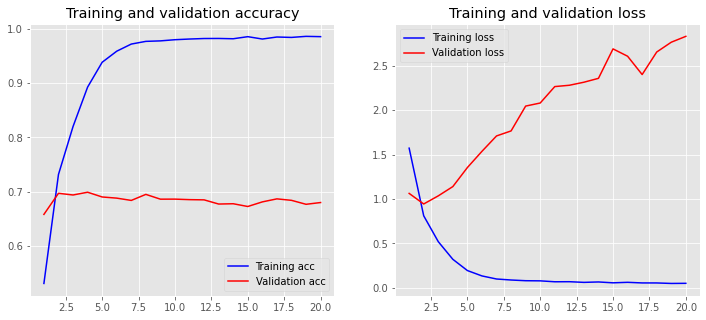

In [231]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=2,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
Модель заоверфитилась на тестовые данные к 10-й эпохе. Точность на 10-й эпохе 0.69 (лучший результат = 0.69; baseline = 0.40 )

## Hyperparameters with RandomizedSearchCV

In [229]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[vocab_size], 
                  embedding_dim=[embedding_dim],
                  maxlen=[maxlen])

In [234]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(num_categories, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

epochs = 20

model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=1)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

test_accuracy = grid.score(X_test, y_test)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [240]:
print (grid_result.best_score_)
print (grid_result.best_params_)

0.6750423014163971
{'vocab_size': 5000, 'num_filters': 128, 'maxlen': 100, 'kernel_size': 3, 'embedding_dim': 50}


## LSTM

In [ ]:
Тренировка LSTM занимает много времени. Ниже приведены данные нескольких экспериментов.

In [113]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten, Conv1D
from keras.wrappers.scikit_learn import KerasClassifier

X = np.array(raw_X)
y = np.array(raw_y)

print (X.shape)

reshaped_X = []
for data in X_train:
    arr = np.array(data)
    newarr = arr.reshape(300,1)
    reshaped_X.append(newarr)
    
#reshaped_X = np.array(reshaped_X)


input_dim = np.array(X_train).shape[1]

def get_model():
    global input_dim
    model = Sequential()
    model.add(LSTM(1, dropout=0.2, input_shape=(300,1), recurrent_dropout=0.2))
    model.add(Dense(100, activation='softmax'))
    model.summary()
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=get_model, nb_epoch=10, batch_size=5, verbose=2)
estimator.fit(np.array(reshaped_X), np.array(y_train), epochs=2, verbose=2)

(23789, 300)
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_41 (Dense)             (None, 100)               200       
Total params: 212
Trainable params: 212
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 - 282s - loss: 2.6156 - accuracy: 0.2722
Epoch 2/10
 - 293s - loss: 2.1312 - accuracy: 0.2770
Epoch 3/10
 - 328s - loss: 2.1120 - accuracy: 0.2770
Epoch 4/10
 - 297s - loss: 2.1085 - accuracy: 0.2770
Epoch 5/10
 - 277s - loss: 2.1075 - accuracy: 0.2770
Epoch 6/10
 - 270s - loss: 2.1066 - accuracy: 0.2770
Epoch 7/10
 - 270s - loss: 2.1049 - accuracy: 0.2770
Epoch 8/10
 - 271s - loss: 2.1012 - accuracy: 0.2775
Epoch 9/10
 - 270s - loss: 2.0941 - accuracy: 0.2801
Epoch 10/10
 - 277s - loss:

In [118]:
reshaped_X_test = []
for data in X_test:
    arr = np.array(data)
    newarr = arr.reshape(300,1)
    reshaped_X_test.append(newarr)

y_pred = estimator.predict(np.array(reshaped_X_test))

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

Accuracy: 0.28709718507196536

              precision    recall  f1-score   support

           1       0.29      0.99      0.45      2159
           4       0.27      0.19      0.23       651
          10       0.00      0.00      0.00       411
          13       0.00      0.00      0.00       362
          14       0.00      0.00      0.00      1048
          20       0.00      0.00      0.00       441
          25       0.00      0.00      0.00       404
          35       0.00      0.00      0.00      1200
          46       0.00      0.00      0.00       731
          91       0.00      0.00      0.00       444

    accuracy                           0.29      7851
   macro avg       0.06      0.12      0.07      7851
weighted avg       0.10      0.29      0.14      7851



/Users/dmytromindra/Projects/prj-nlp-2020/students/DmytroMindra/11-nn/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [122]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten, Conv1D
from keras.wrappers.scikit_learn import KerasClassifier

X = np.array(raw_X)
y = np.array(raw_y)

print (X.shape)

reshaped_X = []
for data in X_train:
    arr = np.array(data)
    newarr = arr.reshape(300,1)
    reshaped_X.append(newarr)
    
#reshaped_X = np.array(reshaped_X)


input_dim = np.array(X_train).shape[1]

def get_model():
    global input_dim
    model = Sequential()

    #model.add(Dense(300, input_dim=input_dim, activation='relu', return_sequences=True))
    #model.add(Conv1D(100,5, input_dim=input_dim, padding = 'same'))
    model.add(LSTM(2, dropout=0.2, input_shape=(300,1), recurrent_dropout=0.2))
    model.add(Dense(100, activation='softmax'))
    model.summary()
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=get_model, nb_epoch=10, batch_size=5, verbose=2)
estimator.fit(np.array(reshaped_X), np.array(y_train), epochs=10, verbose=2)

reshaped_X_test = []
for data in X_test:
    arr = np.array(data)
    newarr = arr.reshape(300,1)
    reshaped_X_test.append(newarr)

y_pred = estimator.predict(np.array(reshaped_X_test))

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

(23789, 300)
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 2)                 32        
_________________________________________________________________
dense_45 (Dense)             (None, 100)               300       
Total params: 332
Trainable params: 332
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 - 274s - loss: 2.4630 - accuracy: 0.2758
Epoch 2/10
 - 271s - loss: 2.1181 - accuracy: 0.2770
Epoch 3/10
 - 270s - loss: 2.1102 - accuracy: 0.2770
Epoch 4/10
 - 270s - loss: 2.1084 - accuracy: 0.2770
Epoch 5/10
 - 271s - loss: 2.1077 - accuracy: 0.2770
Epoch 6/10
 - 271s - loss: 2.1078 - accuracy: 0.2770
Epoch 7/10
 - 271s - loss: 2.1079 - accuracy: 0.2770
Epoch 8/10
 - 271s - loss: 2.1079 - accuracy: 0.2770
Epoch 9/10
 - 270s - loss: 2.1077 - accuracy: 0.2770
Epoch 10/10
 - 300s - loss:

In [123]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten, Conv1D
from keras.wrappers.scikit_learn import KerasClassifier

X = np.array(raw_X)
y = np.array(raw_y)

print (X.shape)

reshaped_X = []
for data in X_train:
    arr = np.array(data)
    newarr = arr.reshape(300,1)
    reshaped_X.append(newarr)
    
#reshaped_X = np.array(reshaped_X)


input_dim = np.array(X_train).shape[1]

def get_model():
    global input_dim
    model = Sequential()

    #model.add(Dense(300, input_dim=input_dim, activation='relu', return_sequences=True))
    #model.add(Conv1D(100,5, input_dim=input_dim, padding = 'same'))
    model.add(LSTM(10, dropout=0.2, input_shape=(300,1), recurrent_dropout=0.2))
    model.add(Dense(100, activation='softmax'))
    model.summary()
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=get_model, nb_epoch=10, batch_size=5, verbose=2)
estimator.fit(np.array(reshaped_X), np.array(y_train), epochs=10, verbose=2)

reshaped_X_test = []
for data in X_test:
    arr = np.array(data)
    newarr = arr.reshape(300,1)
    reshaped_X_test.append(newarr)

y_pred = estimator.predict(np.array(reshaped_X_test))

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

(23789, 300)
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 10)                480       
_________________________________________________________________
dense_46 (Dense)             (None, 100)               1100      
Total params: 1,580
Trainable params: 1,580
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 - 355s - loss: 2.2147 - accuracy: 0.2750
Epoch 2/10
 - 318s - loss: 2.1086 - accuracy: 0.2770
Epoch 3/10
 - 303s - loss: 2.0980 - accuracy: 0.2770
Epoch 4/10
 - 315s - loss: 2.0865 - accuracy: 0.2810
Epoch 5/10
 - 301s - loss: 2.0776 - accuracy: 0.2832
Epoch 6/10
 - 310s - loss: 2.0719 - accuracy: 0.2840
Epoch 7/10
 - 308s - loss: 2.0661 - accuracy: 0.2844
Epoch 8/10
 - 333s - loss: 2.0570 - accuracy: 0.2877
Epoch 9/10
 - 324s - loss: 2.0489 - accuracy: 0.2894
Epoch 10/10
 - 288s - l